<a href="https://colab.research.google.com/github/ViniciusLabruna/previsao-teus-cabotagem/blob/main/A3_Vers%C3%A3o_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Volume de TEUs para Cabotagem no Brasil em 2025



# 1.INTRODUÇÃO

1.1 O que é Cabotagem?

Cabotagem é o transporte marítimo de cargas realizado entre portos de um mesmo país. No Brasil, essa modalidade é muito utilizada devido à extensa costa, sendo uma alternativa ao transporte rodoviário. A cabotagem é mais sustentável e econômica para grandes volumes de carga.
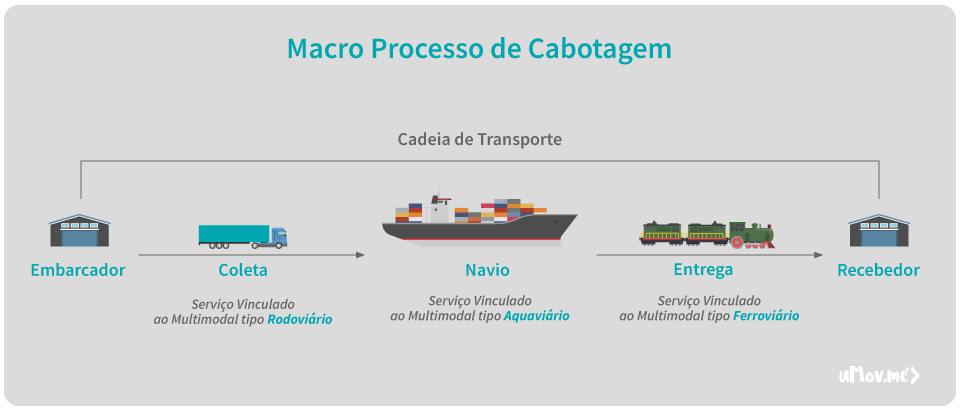
<br>
1.2 O que é TEU?<br>
TEU (Twenty-foot Equivalent Unit) é uma unidade de medida padrão no transporte marítimo, usada para descrever a capacidade de um contêiner ou o volume de carga transportado. Um TEU equivale ao tamanho de um contêiner de 20 pés.
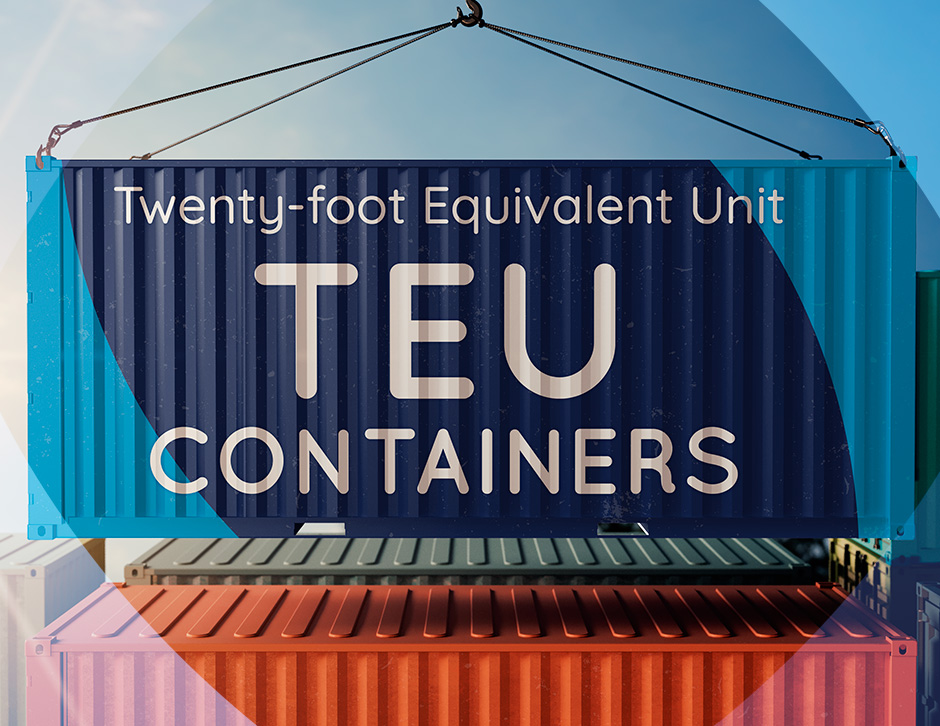


# 2. Explicação do Projeto

O objetivo do projeto é utilizar dados históricos de movimentação de cargas em cabotagem fornecidos pela ANTAQ (Agência Nacional de Transportes Aquaviários), de 2019 até Setembro de 2024, para prever a demanda de TEUs no Brasil em 2025.

Os dados foram processados, tratados e utilizados para construir uma previsão usando o modelo Prophet, que é especialmente adequado para séries temporais com padrões sazonais e tendências.

# 3. Modelo Prophet e sua Escolha

<p>
O Prophet, desenvolvido pelo Facebook, é uma ferramenta robusta para modelagem de séries temporais, ideal para lidar com padrões sazonais, tendências não lineares e lacunas nos dados. Ele se destaca por sua facilidade de uso, identificação automática de sazonalidades e geração de intervalos de confiança.
</p>

<p>
<strong>Foi escolhido para este projeto por:</strong>
</p>
<ul>
  <li><strong>Sazonalidade Anual:</strong> Captura flutuações ligadas a períodos econômicos e festivos.</li>
  <li><strong>Robustez:</strong> Lida bem com dados incompletos ou ruidosos.</li>
  <li><strong>Previsão de Longo Prazo:</strong> Adequado para projeções até 2025.</li>
  <li><strong>Facilidade de Implementação:</strong> Integra-se facilmente ao pipeline.</li>
</ul>

<p>
Apesar de supor que a sazonalidade passada persista no futuro, suas características o tornam ideal para prever volumes de TEUs na cabotagem, proporcionando análises confiáveis e de fácil interpretação.
</p>

# 4. Importação de Dados e Pré-Processamento


<p>
Carregamos os arquivos txt de 2019 até 2024, importados da ANTAQ, de Carga para saber a quantidade de TEU e o de Atracação para saber a Data de Atracação, por fim, filtramos apenas por essas duas colunas que serão utilizadas para a análise da previsão.
</p>


In [35]:
import pandas as pd
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Lista de arquivos de carga
carga_file_paths = [
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2019Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2020Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2021Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2022Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2023Carga.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2024Carga.txt'
]

# Carregar e concatenar os dados em uma única etapa
df_carga = pd.concat(
    (pd.read_csv(file, sep=';', encoding='utf-8', low_memory=False) for file in carga_file_paths),
    ignore_index=True
)

df_carga = df_carga[df_carga['Tipo Operação da Carga'] == 'Cabotagem']
df_carga = df_carga[['IDAtracacao', 'TEU']]

# Lista de arquivos de atracação
atracacao_file_paths = [
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2019Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2020Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2021Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2022Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2023Atracacao.txt',
    '/content/drive/MyDrive/Projeto A3 - Previsao de Demanda de Carga na Cabotagem/2024Atracacao.txt'
]

# Carregar e concatenar os dados em uma única etapa
df_atracacao = pd.concat(
    (pd.read_csv(file, sep=';', encoding='utf-8', low_memory=False) for file in atracacao_file_paths),
    ignore_index=True
)

# Definir os campos necessários para a análise
df_atracacao = df_atracacao[['IDAtracacao', 'Data Atracação']]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 5. Merge e indentificação dos Dados


<p>
Combinamos os dados de Carga e Atracação por meio da chave IDAtracacao, e checamos os tipos de dados.
</p>


In [40]:
# Realizar o merge
df_cabotagem = pd.merge(
    df_carga,
    df_atracacao,
    on='IDAtracacao',  # Coluna para ligar os DataFrames
    how='inner'        # Tipo de junção (inner: apenas correspondências)
)

# Verficando os tipos de dados
print(df_cabotagem.dtypes)

# Verificando os primeiro 5 dados
print(df_cabotagem.head(5))

IDAtracacao        int64
TEU               object
Data Atracação    object
dtype: object
   IDAtracacao TEU       Data Atracação
0       967436   0  31/12/2018 15:35:00
1       967436   0  31/12/2018 15:35:00
2       967436   0  31/12/2018 15:35:00
3       967437   0  01/01/2019 17:42:00
4       967437   0  01/01/2019 17:42:00


# 6.Limpeza e Conversão de Dados


<p>
Garantimos que os dados estão no formato correto e que entradas inválidas sejam removidas. Também removendo alguns dados de final 2018 de estão presentes nos arquivos de 2019.
</p>


In [42]:
# Convertendo 'TEU' para numérico, tratando erros
df_cabotagem['TEU'] = pd.to_numeric(df_cabotagem['TEU'], errors='coerce')

# Convertendo 'Data Atracação' para datetime, tratando erros
df_cabotagem['Data Atracação'] = pd.to_datetime(df_cabotagem['Data Atracação'], errors='coerce', dayfirst=True)

# Exibindo os tipos de dados após a conversão
print(df_cabotagem.dtypes)

# Verificando os primeiro 5 dados
print(df_cabotagem.head(5))

# Removendo linhas com valores NaN após a conversão
df_cabotagem.dropna(subset=['TEU', 'Data Atracação'], inplace=True)

# Removendo linhas com valores duplicados
df_cabotagem = df_cabotagem.drop_duplicates()

# Removendo dados de final de 2018 presentes nos arquivos de 2019
df_cabotagem = df_cabotagem[df_cabotagem['Data Atracação'].dt.year >= 2019]

IDAtracacao                int64
TEU                      float64
Data Atracação    datetime64[ns]
dtype: object
    IDAtracacao  TEU      Data Atracação
3        967437  0.0 2019-01-01 17:42:00
6        967523  0.0 2019-01-02 21:20:00
7        967588  0.0 2019-01-01 15:00:00
15       967971  0.0 2019-01-06 07:30:00
32       968072  0.0 2019-01-01 10:10:00



# 7. Visualização do Volume de TEUs e Previsão



<p>
Geramos uma visualização gráfica que mostra a evolução do volume de TEUs ao longo do tempo, de 2019 a 2025. O gráfico destaca tanto os dados reais observados quanto as previsões futuras realizadas pelo modelo Prophet, com um foco especial nos anos de 2024 e 2025.
</p>

<ul>
  <li><strong>Dados Reais (2019-2024):</strong> Representados por uma linha azul contínua com pontos, estes dados refletem o histórico observado do volume de TEUs, desde 2019 até setembro de 2024. Este conjunto de dados fornece a base para as previsões e mostra o comportamento real do setor de cabotagem durante esse período.</li>
  <li><strong>Previsões (2024-2025):</strong>
    <ul>
      <li><strong>Previsões até setembro de 2024:</strong> Os pontos pretos representam as previsões feitas pelo modelo Prophet até o final de setembro de 2024, com base nos dados históricos.</li>
      <li><strong>Previsões de outubro a dezembro de 2024:</strong> Uma linha verde pontilhada mostra as previsões para os últimos três meses de 2024, projetando o comportamento do volume de TEUs para o final do ano.</li>
      <li><strong>Previsões para 2025:</strong> Uma linha laranja pontilhada ilustra as previsões do modelo Prophet para o ano de 2025, permitindo uma visão das expectativas para o próximo ano.</li>
    </ul>
  </li>
  <li><strong>Intervalo de Confiança:</strong> A área sombreada em azul claro reflete a incerteza associada às previsões, representando a margem de erro do modelo Prophet para o período de 2024 a 2025. Este intervalo de confiança fornece uma noção visual da variabilidade das previsões, ajudando na compreensão dos limites da precisão do modelo.</li>
</ul>

<p>
O gráfico também inclui algumas configurações visuais importantes para melhorar a legibilidade e a interpretação dos dados:
</p>
<ul>
  <li><strong>Eixo Y:</strong> O eixo Y foi limitado para destacar os volumes de TEUs em um intervalo entre 100.000 e 220.000, tornando mais fácil visualizar as variações significativas nos dados.</li>
  <li><strong>Rótulos dos Eixos:</strong> Os rótulos do eixo X e Y foram ajustados para garantir uma leitura clara e precisa das datas e dos volumes de TEUs.</li>
  <li><strong>Transição entre Dados Reais e Previsões:</strong> Uma linha azul conecta o último ponto de dados reais (setembro de 2024) à primeira previsão para outubro de 2024, garantindo uma transição contínua entre os dados observados e as previsões futuras.</li>
</ul>


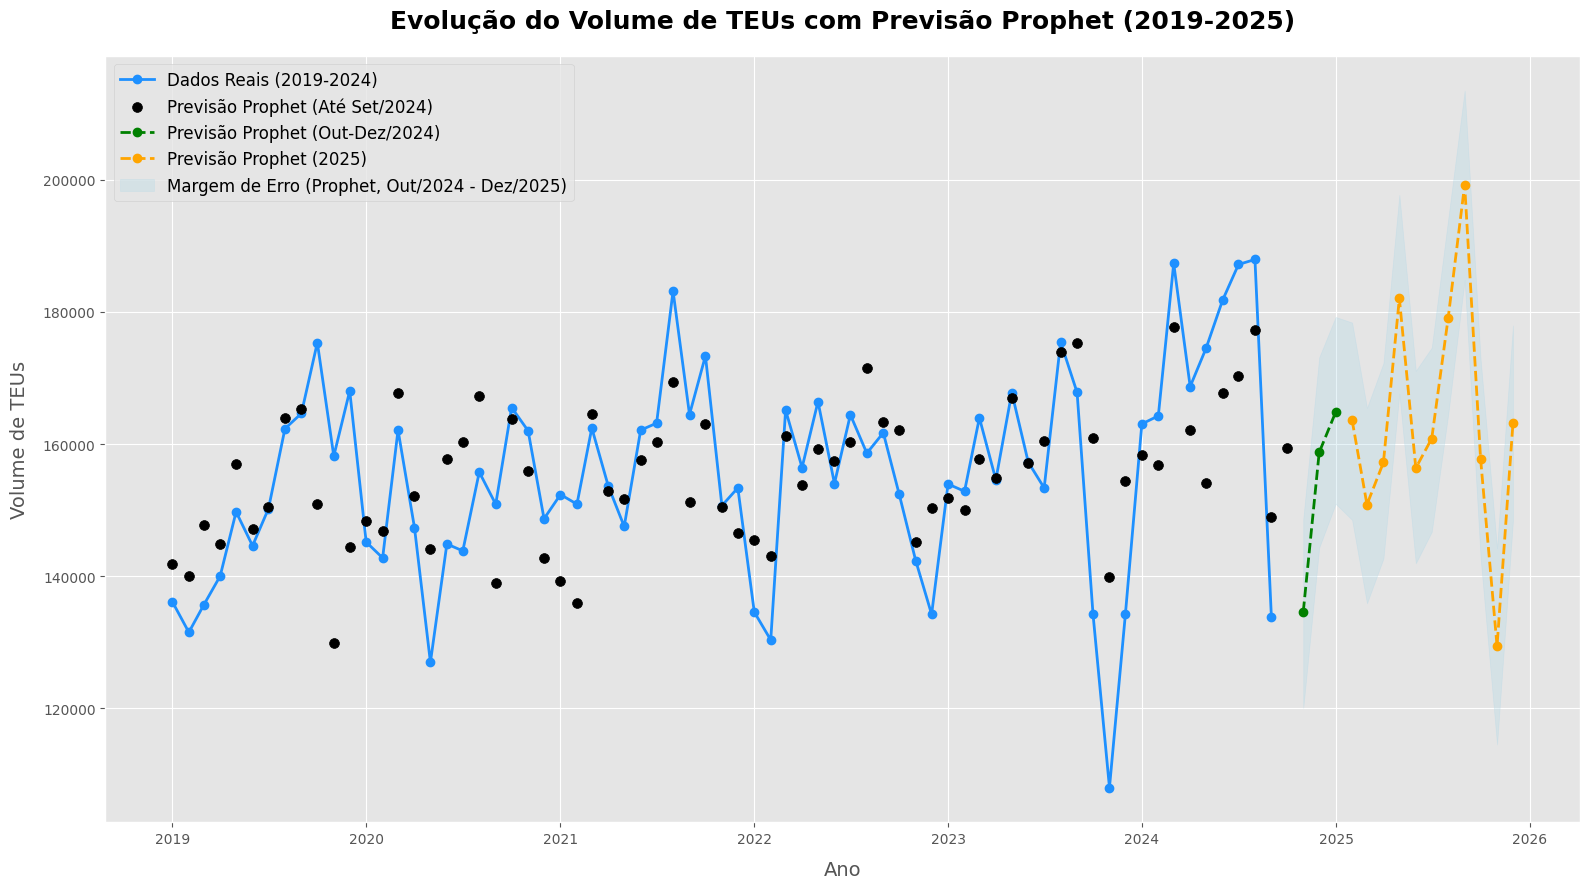

In [44]:
from prophet import Prophet
import matplotlib.pyplot as plt
import logging

# Definir o nível de log para WARNING (ou ERROR para menos verbosidade)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Configuração do estilo do gráfico para um visual mais limpo e intuitivo
plt.style.use('ggplot')

# Definindo o tamanho da figura (largura e altura) para uma melhor visualização
plt.figure(figsize=(16, 9))

# Filtrar os dados até setembro de 2024 (inclusive) para análise
df_filtered = df_cabotagem[df_cabotagem['Data Atracação'] <= '2024-09-30']

# Conversão das datas para o formato de período mensal
monthly_teu = df_filtered.groupby(df_filtered['Data Atracação'].dt.to_period('M'))['TEU'].sum()

# Converter os índices (períodos) para o formato datetime para facilitar a plotagem
monthly_teu.index = monthly_teu.index.to_timestamp()

# Adicionar a linha de dados reais (de 2019 até setembro de 2024) ao gráfico
plt.plot(
    monthly_teu.index,
    monthly_teu.values,
    marker='o',
    linestyle='-',
    linewidth=2.0,
    color='dodgerblue',
    label='Dados Reais (2019-2024)'
)

# O modelo é configurado com sazonalidade anual, mas sem sazonalidade semanal ou diária
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df_prophet)  # Treinamento do modelo Prophet com os dados históricos

# 'periods=15' indica o número de meses a serem previstos
future_dates = model.make_future_dataframe(periods=15, freq='ME')  # Frequência mensal
forecast = model.predict(future_dates)  # Realizar as previsões para o futuro

# Selecionar apenas as colunas relevantes do forecast (previsão e intervalos de confiança)
forecast_filtered = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # Previsão e intervalos
forecast_filtered.set_index('ds', inplace=True)  # Configurar 'ds' (datas) como índice para fácil acesso

# Previsões Prophet até setembro de 2024 - Representadas por bolinhas pretas
forecast_to_sep = forecast_filtered.loc[:'2024-09-30']
plt.scatter(
    forecast_to_sep.index,
    forecast_to_sep['yhat'],
    color='black',
    label='Previsão Prophet (Até Set/2024)',
    zorder=3,
    s=50
)

# Previsões Prophet de outubro a dezembro de 2024 - Representadas por linha verde pontilhada
forecast_oct_to_dec = forecast_filtered.loc['2024-10-01':'2024-12-31']
plt.plot(
    forecast_oct_to_dec.index,
    forecast_oct_to_dec['yhat'],
    marker='o',
    linestyle='--',
    linewidth=2.0,
    color='green',
    label='Previsão Prophet (Out-Dez/2024)'
)

# Previsões Prophet após dezembro de 2024 - Representadas por linha laranja pontilhada
forecast_post_dec = forecast_filtered.loc['2025-01-01':]
plt.plot(
    forecast_post_dec.index,
    forecast_post_dec['yhat'],
    marker='o',
    linestyle='--',
    linewidth=2.0,
    color='orange',
    label='Previsão Prophet (2025)'
)

# Preenchendo a área entre as previsões inferior e superior (intervalo de confiança)
forecast_with_ci = forecast_filtered.loc['2024-10-01':'2025-12-31']
plt.fill_between(
    forecast_with_ci.index,       #
    forecast_with_ci['yhat_lower'],
    forecast_with_ci['yhat_upper'],
    color='lightblue',
    alpha=0.3,
    label='Margem de Erro (Prophet, Out/2024 - Dez/2025)'
)

# Preenchendo gap para garantir que a linha de dados reais e a previsão estejam conectadas
if '2024-10-01' in forecast_filtered.index:
    # Plotando uma linha conectando o final de setembro de 2024 com a previsão de outubro de 2024
    plt.plot(
        ['2024-09-30', '2024-10-01'],  # Conectar as duas datas (último dia de setembro e o primeiro de outubro)
        [monthly_teu.loc['2024-09-01':'2024-09-30'].values[-1], forecast_filtered.loc['2024-10-01']['yhat']],
        linestyle='-',
        color='dodgerblue',
        linewidth=2.0,
        zorder=1
    )

# 9. Configurações gerais do gráfico (título, rótulos e exibição)
plt.title('Evolução do Volume de TEUs com Previsão Prophet (2019-2025)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Ano', fontsize=14, labelpad=10)
plt.ylabel('Volume de TEUs', fontsize=14, labelpad=10)

# Adicionar legenda ao gráfico
plt.legend(fontsize=12, loc='upper left', frameon=True)

# Ajustar o tamanho das fontes dos rótulos no eixo Y
plt.yticks(fontsize=10)

# Exibir o gráfico com ajustes finais
plt.tight_layout()
plt.show()


# 7. Conclusão

<p>
Este projeto teve como objetivo acadêmico explorar a previsão do volume de TEUs na cabotagem no Brasil em 2025, utilizando apenas dados históricos disponibilizados pela ANTAQ. Através da análise sazonal e da aplicação do modelo Prophet, foi possível identificar padrões históricos de volume que refletem a dinâmica do setor ao longo dos anos.
</p>

<p>
As previsões geradas consideram a sazonalidade dos dados, mas é importante ressaltar que o modelo não leva em conta fatores externos como variações econômicas, mudanças políticas, climáticas ou outras variáveis exógenas que podem impactar significativamente as operações de cabotagem.
</p>

<p>
Embora os resultados ofereçam uma boa base para análise, reforça-se que as projeções são baseadas em tendências passadas e não devem ser interpretadas como garantias de comportamento futuro. Este projeto destaca o potencial das técnicas de machine learning e análise de séries temporais no estudo acadêmico de setores logísticos, ao mesmo tempo em que evidencia a importância de considerar variáveis externas para uma análise mais completa em estudos futuros.
</p>
